Pip Install

In [ ]:
!pip install torch torchvision numpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

Imports and Initialization

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.quantization
import os
import time
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import random


# Set random seed for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)


# First check if CUDA is available
cuda_available = torch.cuda.is_available()
train_device = torch.device("cuda:0" if cuda_available else "cpu")
print(f"Using device for training: {train_device}")





Using device for training: cuda:0


Model Definition

In [ ]:
# Define a CNN model for CIFAR10
class CIFAR10CNN(nn.Module):
   def __init__(self):
       super(CIFAR10CNN, self).__init__()
       self.features = nn.Sequential(
           nn.Conv2d(3, 64, kernel_size=3, padding=1),
           nn.ReLU(inplace=True),
           nn.MaxPool2d(kernel_size=2),


           nn.Conv2d(64, 128, kernel_size=3, padding=1),
           nn.ReLU(inplace=True),
           nn.MaxPool2d(kernel_size=2),


           nn.Conv2d(128, 256, kernel_size=3, padding=1),
           nn.ReLU(inplace=True),
           nn.MaxPool2d(kernel_size=2),
       )


       self.classifier = nn.Sequential(
           nn.Flatten(),
           nn.Linear(256 * 4 * 4, 1024),
           nn.ReLU(inplace=True),
           nn.Linear(1024, 10)
       )


   def forward(self, x):
       x = self.features(x)
       x = self.classifier(x)
       return x


Loading Dataset

In [ ]:
# Data loading and preprocessing
def load_data(batch_size=128):
   transform_train = transforms.Compose([
       transforms.RandomCrop(32, padding=4),
       transforms.RandomHorizontalFlip(),
       transforms.ToTensor(),
       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
   ])


   transform_test = transforms.Compose([
       transforms.ToTensor(),
       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
   ])


   train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform_train)
   test_dataset = datasets.CIFAR10('./data', train=False, download=True, transform=transform_test)


   # For faster demonstration, use a subset of training data
   train_indices = list(range(len(train_dataset)))
   random.shuffle(train_indices)
   train_indices = train_indices[:10000]  # Use 10,000 samples for training


   train_subset = Subset(train_dataset, train_indices)


   train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
   test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


   return train_loader, test_loader


# Load data
batch_size = 128
train_loader, test_loader = load_data(batch_size)


# CPU dataloader for quantization operations
test_loader_cpu = DataLoader(
   datasets.CIFAR10('./data', train=False, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    ])),
   batch_size=batch_size, shuffle=False)




100%|██████████| 170M/170M [00:12<00:00, 13.2MB/s]


Utils for Evaluation

In [ ]:
# Utility functions
def get_model_size(model):
   """Calculate the model size in MB"""
   torch.save(model.state_dict(), "temp.p")
   size = os.path.getsize("temp.p")/1e6
   os.remove('temp.p')
   return size


def evaluate_model(model, dataloader, device, num_batches=None):
   """Evaluate model accuracy"""
   model.eval()
   correct = 0
   total = 0


   with torch.no_grad():
       for i, (data, target) in enumerate(dataloader):
           if num_batches is not None and i >= num_batches:
               break


           data, target = data.to(device), target.to(device)
           outputs = model(data)
           _, predicted = torch.max(outputs.data, 1)
           total += target.size(0)
           correct += (predicted == target).sum().item()


   return correct / total


def measure_inference_time(model, dataloader, device, num_runs=100):
   """Measure inference time"""
   model.eval()


   # Get a batch for testing
   data_iter = iter(dataloader)
   batch, _ = next(data_iter)
   batch = batch.to(device)


   # Warmup
   with torch.no_grad():
       for _ in range(10):
           _ = model(batch)


   # Measure inference time
   start_time = time.time()
   with torch.no_grad():
       for _ in range(num_runs):
           _ = model(batch)
   end_time = time.time()


   avg_time = (end_time - start_time) / num_runs
   return avg_time




Training

In [ ]:
def train_model(model, train_loader, optimizer, criterion, device, epochs=5):
   """Train the model"""
   model.train()
   training_losses = []


   for epoch in range(epochs):
       running_loss = 0.0
       for i, (inputs, labels) in enumerate(train_loader):
           inputs, labels = inputs.to(device), labels.to(device)


           # Zero the parameter gradients
           optimizer.zero_grad()


           # Forward + backward + optimize
           outputs = model(inputs)
           loss = criterion(outputs, labels)
           loss.backward()
           optimizer.step()


           # Print statistics
           running_loss += loss.item()
           if i % 100 == 99:  # Print every 100 mini-batches
               print(f'Epoch {epoch+1}, Batch {i+1}: Loss = {running_loss/100:.4f}')
               training_losses.append(running_loss/100)
               running_loss = 0.0


   return training_losses

# Train and evaluate regular model (baseline)
print("\n" + "="*50)
print("BASELINE MODEL TRAINING AND EVALUATION")
print("="*50)


model_fp32 = CIFAR10CNN().to(train_device)
optimizer = optim.Adam(model_fp32.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


print("Training baseline model...")
train_losses = train_model(
   model_fp32, train_loader, optimizer, criterion, train_device, epochs=3
)


# Evaluate on the same device used for training
print("Evaluating baseline model...")
fp32_accuracy = evaluate_model(model_fp32, test_loader, train_device)
fp32_inference_time = measure_inference_time(model_fp32, test_loader, train_device)
fp32_size = get_model_size(model_fp32)
print(f"FP32 Model Accuracy: {fp32_accuracy:.4f}")
print(f"FP32 Inference Time per batch: {fp32_inference_time*1000:.2f} ms")
print(f"FP32 Model Size: {fp32_size:.2f} MB")


# Save the model state dict for later use
torch.save(model_fp32.state_dict(), "fp32_model.pth")


# Move model to CPU for quantization operations
model_fp32_cpu = CIFAR10CNN()
model_fp32_cpu.load_state_dict(model_fp32.state_dict())
model_fp32_cpu.eval()


# For fair comparison, also measure FP32 performance on CPU
fp32_cpu_inference_time = measure_inference_time(model_fp32_cpu, test_loader_cpu, "cpu")
print(f"FP32 Inference Time on CPU: {fp32_cpu_inference_time*1000:.2f} ms")



BASELINE MODEL TRAINING AND EVALUATION
Training baseline model...
Evaluating baseline model...
FP32 Model Accuracy: 0.5279
FP32 Inference Time per batch: 2.38 ms
FP32 Model Size: 18.31 MB
FP32 Inference Time on CPU: 201.40 ms


Dynamic Quantization


POST-TRAINING DYNAMIC QUANTIZATION (CPU)
Applying dynamic quantization...
Evaluating dynamically quantized model on CPU...
Dynamic Quantized Model Accuracy: 0.5277
Accuracy Change: -0.02%
Dynamic Quantized Inference Time (CPU): 192.78 ms
FP32 Inference Time (CPU): 201.40 ms
Speedup vs FP32 on CPU: 1.04x
Dynamic Quantized Model Size: 5.70 MB
Size Reduction: 68.89%


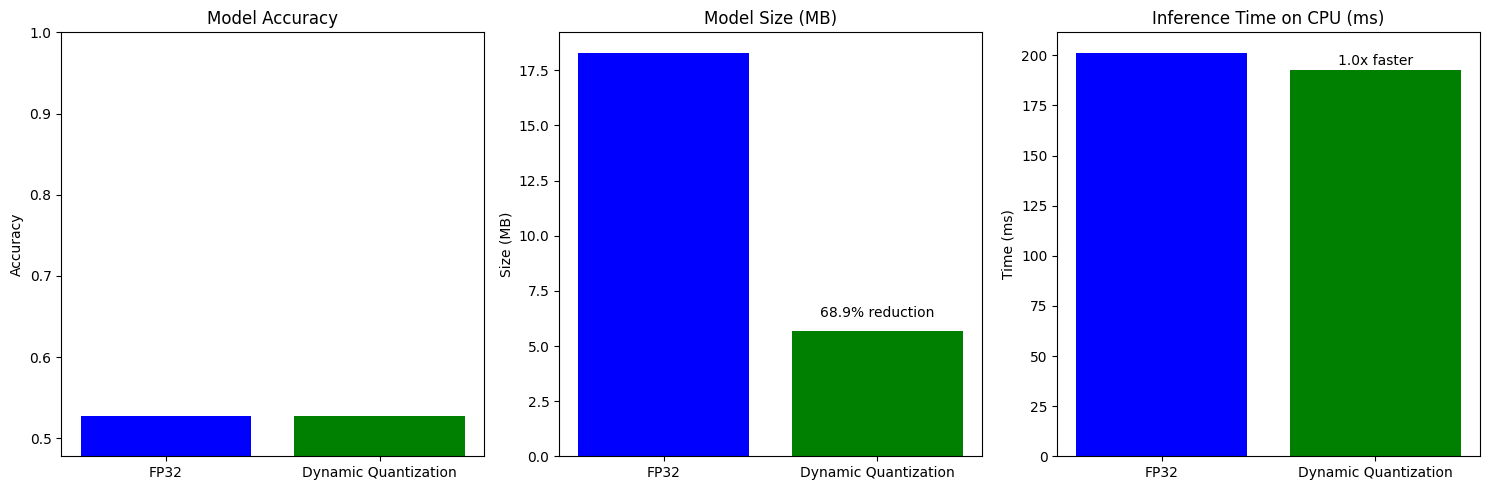

In [ ]:
# This notebook assumes you've run Part 1 to train the baseline model
# and have the following variables available:
# - model_fp32_cpu: The baseline CPU model
# - test_loader_cpu: DataLoader for CPU testing
# - fp32_accuracy: Baseline accuracy
# - fp32_size: Baseline model size
# - fp32_cpu_inference_time: Baseline CPU inference time


# Post-Training Dynamic Quantization
print("\n" + "="*50)
print("POST-TRAINING DYNAMIC QUANTIZATION (CPU)")
print("="*50)


# Apply dynamic quantization on CPU model
print("Applying dynamic quantization...")
model_dynamic = torch.quantization.quantize_dynamic(
   model_fp32_cpu,  # Use CPU model
   {nn.Linear, nn.Conv2d},  # Quantize both linear and conv layers
   dtype=torch.qint8  # Use 8-bit integers
)


# Evaluate dynamically quantized model (always on CPU)
print("Evaluating dynamically quantized model on CPU...")
dynamic_accuracy = evaluate_model(model_dynamic, test_loader_cpu, "cpu")
dynamic_inference_time = measure_inference_time(model_dynamic, test_loader_cpu, "cpu")
dynamic_size = get_model_size(model_dynamic)


print(f"Dynamic Quantized Model Accuracy: {dynamic_accuracy:.4f}")
print(f"Accuracy Change: {(dynamic_accuracy - fp32_accuracy)*100:.2f}%")
print(f"Dynamic Quantized Inference Time (CPU): {dynamic_inference_time*1000:.2f} ms")
print(f"FP32 Inference Time (CPU): {fp32_cpu_inference_time*1000:.2f} ms")
print(f"Speedup vs FP32 on CPU: {fp32_cpu_inference_time/dynamic_inference_time:.2f}x")
print(f"Dynamic Quantized Model Size: {dynamic_size:.2f} MB")
print(f"Size Reduction: {(1 - dynamic_size/fp32_size)*100:.2f}%")


# Visualization for Dynamic Quantization vs FP32
plt.figure(figsize=(15, 5))


# Accuracy comparison
plt.subplot(1, 3, 1)
models = ['FP32', 'Dynamic Quantization']
accuracies = [fp32_accuracy, dynamic_accuracy]
plt.bar(models, accuracies, color=['blue', 'green'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.ylim(min(accuracies) - 0.05, 1.0)


# Size comparison
plt.subplot(1, 3, 2)
sizes = [fp32_size, dynamic_size]
bars = plt.bar(models, sizes, color=['blue', 'green'])
plt.title('Model Size (MB)')
plt.ylabel('Size (MB)')
# Add percentage reduction label
reduction = (1 - dynamic_size/fp32_size) * 100
plt.text(bars[1].get_x() + bars[1].get_width()/2, dynamic_size + 0.5,
        f"{reduction:.1f}% reduction",
        ha='center', va='bottom')


# Inference time comparison (all on CPU for fair comparison)
plt.subplot(1, 3, 3)
times = [fp32_cpu_inference_time*1000, dynamic_inference_time*1000]
bars = plt.bar(models, times, color=['blue', 'green'])
plt.title('Inference Time on CPU (ms)')
plt.ylabel('Time (ms)')
# Add speedup label
speedup = fp32_cpu_inference_time/dynamic_inference_time
plt.text(bars[1].get_x() + bars[1].get_width()/2, dynamic_inference_time*1000 + 1,
        f"{speedup:.1f}x faster",
        ha='center', va='bottom')


plt.tight_layout()
plt.savefig('dynamic_quantization_comparison.png')
plt.show()


Static Quantization


POST-TRAINING STATIC QUANTIZATION (CPU)
Preparing model for static quantization...
Calibrating with test data...


/usr/local/lib/python3.11/dist-packages/torch/ao/quantization/observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


Converting to quantized model...
Evaluating statically quantized model on CPU...
Static Quantized Model Accuracy: 0.5238
Accuracy Change: -0.41%
Static Quantized Inference Time (CPU): 127.43 ms
Speedup vs FP32 on CPU: 1.58x
Static Quantized Model Size: 4.61 MB
Size Reduction: 74.80%


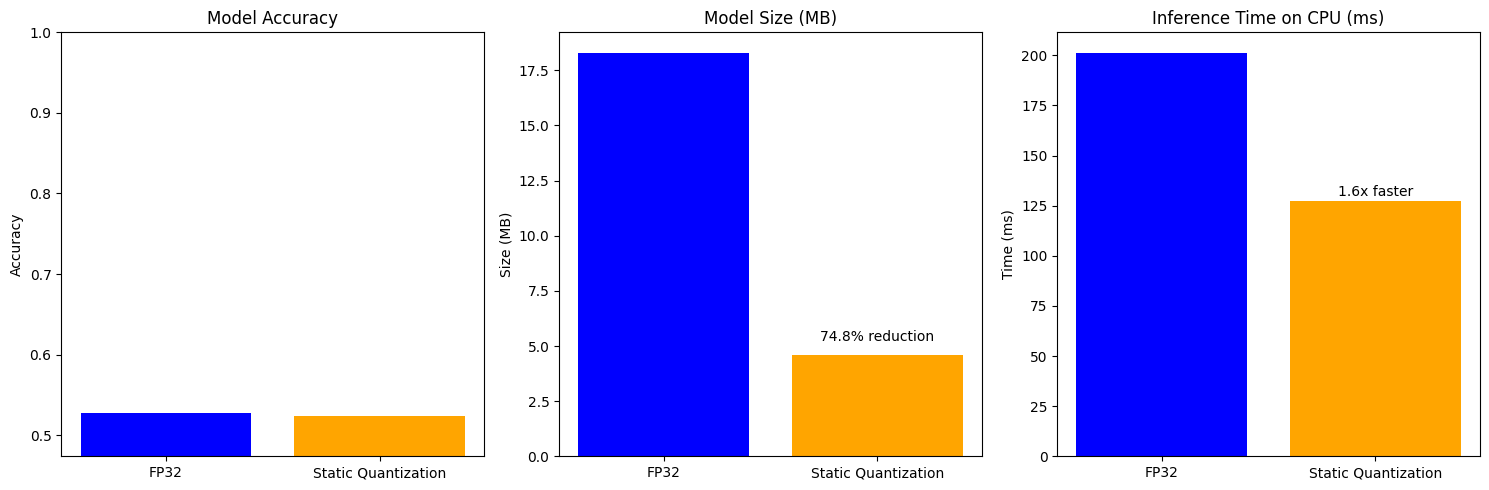

In [ ]:
# This notebook assumes you've run Part 1 to train the baseline model
# and have the following variables available:
# - model_fp32: The trained model
# - test_loader_cpu: DataLoader for CPU testing
# - fp32_accuracy: Baseline accuracy
# - fp32_size: Baseline model size
# - fp32_cpu_inference_time: Baseline CPU inference time


# Static Quantization

print("\n" + "="*50)
print("POST-TRAINING STATIC QUANTIZATION (CPU)")
print("="*50)


# Create quantizable model on CPU
model_static = QuantizableCIFAR10CNN()
# Load state dict from the trained model
model_static.load_state_dict(model_fp32.state_dict())
model_static.eval()


# Configure static quantization
model_static.qconfig = torch.quantization.get_default_qconfig('fbgemm')


# Prepare for static quantization
print("Preparing model for static quantization...")
model_static_prepared = torch.quantization.prepare(model_static)


# Calibration function to determine optimal quantization parameters
def calibrate(model, data_loader, num_batches=10):
   model.eval()
   with torch.no_grad():
       for i, (data, _) in enumerate(data_loader):
           if i >= num_batches:
               break
           # No need to explicitly move to CPU since model is on CPU
           _ = model(data)


# Calibrate with sample data
print("Calibrating with test data...")
calibrate(model_static_prepared, test_loader_cpu)


# Convert to fully quantized model
print("Converting to quantized model...")
model_static_quantized = torch.quantization.convert(model_static_prepared)


# Evaluate statically quantized model on CPU
print("Evaluating statically quantized model on CPU...")
static_accuracy = evaluate_model(model_static_quantized, test_loader_cpu, "cpu")
static_inference_time = measure_inference_time(model_static_quantized, test_loader_cpu, "cpu")
static_size = get_model_size(model_static_quantized)


print(f"Static Quantized Model Accuracy: {static_accuracy:.4f}")
print(f"Accuracy Change: {(static_accuracy - fp32_accuracy)*100:.2f}%")
print(f"Static Quantized Inference Time (CPU): {static_inference_time*1000:.2f} ms")
print(f"Speedup vs FP32 on CPU: {fp32_cpu_inference_time/static_inference_time:.2f}x")
print(f"Static Quantized Model Size: {static_size:.2f} MB")
print(f"Size Reduction: {(1 - static_size/fp32_size)*100:.2f}%")


# Visualization for Static Quantization vs FP32
plt.figure(figsize=(15, 5))


# Accuracy comparison
plt.subplot(1, 3, 1)
models = ['FP32', 'Static Quantization']
accuracies = [fp32_accuracy, static_accuracy]
plt.bar(models, accuracies, color=['blue', 'orange'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.ylim(min(accuracies) - 0.05, 1.0)


# Size comparison
plt.subplot(1, 3, 2)
sizes = [fp32_size, static_size]
bars = plt.bar(models, sizes, color=['blue', 'orange'])
plt.title('Model Size (MB)')
plt.ylabel('Size (MB)')
# Add percentage reduction label
reduction = (1 - static_size/fp32_size) * 100
plt.text(bars[1].get_x() + bars[1].get_width()/2, static_size + 0.5,
        f"{reduction:.1f}% reduction",
        ha='center', va='bottom')


# Inference time comparison
plt.subplot(1, 3, 3)
times = [fp32_cpu_inference_time*1000, static_inference_time*1000]
bars = plt.bar(models, times, color=['blue', 'orange'])
plt.title('Inference Time on CPU (ms)')
plt.ylabel('Time (ms)')
# Add speedup label
speedup = fp32_cpu_inference_time/static_inference_time
plt.text(bars[1].get_x() + bars[1].get_width()/2, static_inference_time*1000 + 1,
        f"{speedup:.1f}x faster",
        ha='center', va='bottom')


plt.tight_layout()
plt.savefig('static_quantization_comparison.png')
plt.show()


Quantization Aware Training


QUANTIZATION-AWARE TRAINING
Initial training phase (FP32)...
Preparing for QAT...
QAT training phase...
Evaluating QAT model before conversion...
QAT Model Accuracy (before conversion): 0.5618
Converting QAT model to deployable quantized model...
Evaluating final QAT model on CPU...
QAT Model Accuracy: 0.5610
Accuracy Change vs FP32: 3.31%
QAT Model Inference Time (CPU): 126.30 ms
Speedup vs FP32 on CPU: 1.59x
QAT Model Size: 4.61 MB
Size Reduction vs FP32: 74.80%


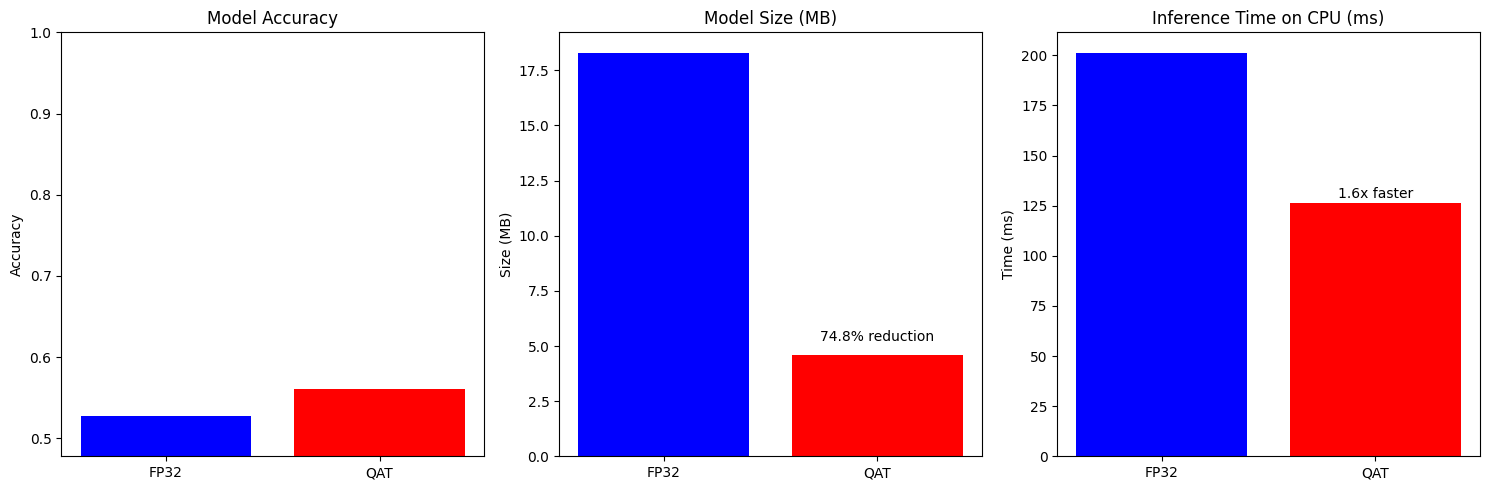

In [ ]:
# This notebook assumes you've run Part 1 to train the baseline model
# and have the following variables available:
# - model_fp32: The trained model
# - train_loader: DataLoader for training
# - test_loader: DataLoader for testing
# - test_loader_cpu: DataLoader for CPU testing
# - fp32_accuracy: Baseline accuracy
# - fp32_size: Baseline model size
# - fp32_cpu_inference_time: Baseline CPU inference time
# - train_device: The device for training (CUDA or CPU)

# Define a QAT-ready model with proper quantization support
class QuantizableCIFAR10CNN(nn.Module):
   def __init__(self):
       super(QuantizableCIFAR10CNN, self).__init__()
       # Quantization stubs
       self.quant = torch.quantization.QuantStub()
       self.dequant = torch.quantization.DeQuantStub()


       # Feature extraction layers
       self.features = nn.Sequential(
           nn.Conv2d(3, 64, kernel_size=3, padding=1),
           nn.ReLU(inplace=True),
           nn.MaxPool2d(kernel_size=2),


           nn.Conv2d(64, 128, kernel_size=3, padding=1),
           nn.ReLU(inplace=True),
           nn.MaxPool2d(kernel_size=2),


           nn.Conv2d(128, 256, kernel_size=3, padding=1),
           nn.ReLU(inplace=True),
           nn.MaxPool2d(kernel_size=2),
       )


       # Classification layers
       self.classifier = nn.Sequential(
           nn.Flatten(),
           nn.Linear(256 * 4 * 4, 1024),
           nn.ReLU(inplace=True),
           nn.Linear(1024, 10)
       )


   def forward(self, x):
       x = self.quant(x)
       x = self.features(x)
       x = self.classifier(x)
       x = self.dequant(x)
       return x



# Quantization-Aware Training
print("\n" + "="*50)
print("QUANTIZATION-AWARE TRAINING")
print("="*50)


# Create new model for QAT
model_qat = QuantizableCIFAR10CNN().to(train_device)
model_qat.load_state_dict(model_fp32.state_dict())


# Configure optimizer with lower learning rate for fine-tuning
optimizer_qat = optim.Adam(model_qat.parameters(), lr=0.0001)
criterion_qat = nn.CrossEntropyLoss()


# Initial training in FP32
print("Initial training phase (FP32)...")
model_qat.train()
for i, (inputs, labels) in enumerate(train_loader):
   if i >= 200:  # Just a few batches for initial FP32 training
       break


   inputs, labels = inputs.to(train_device), labels.to(train_device)
   optimizer_qat.zero_grad()
   outputs = model_qat(inputs)
   loss = criterion_qat(outputs, labels)
   loss.backward()
   optimizer_qat.step()


# Move to CPU for QAT preparation
model_qat = model_qat.cpu()


# Prepare for QAT
print("Preparing for QAT...")
model_qat.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
torch.quantization.prepare_qat(model_qat, inplace=True)


# Move back to training device
model_qat = model_qat.to(train_device)


# QAT training
print("QAT training phase...")
model_qat.train()
qat_losses = []
for epoch in range(2):  # 2 epochs of QAT
   running_loss = 0.0
   for i, (inputs, labels) in enumerate(train_loader):
       inputs, labels = inputs.to(train_device), labels.to(train_device)


       optimizer_qat.zero_grad()
       outputs = model_qat(inputs)
       loss = criterion_qat(outputs, labels)
       loss.backward()
       optimizer_qat.step()


       running_loss += loss.item()
       if i % 100 == 99:
           print(f'QAT Epoch {epoch+1}, Batch {i+1}: Loss = {running_loss/100:.4f}')
           qat_losses.append(running_loss/100)
           running_loss = 0.0


       if i >= 300:  # Limit batches for demonstration
           break


# Evaluate QAT model before final conversion
print("Evaluating QAT model before conversion...")
qat_fp32_accuracy = evaluate_model(model_qat, test_loader, train_device)
print(f"QAT Model Accuracy (before conversion): {qat_fp32_accuracy:.4f}")


# Convert QAT model to fully quantized model (on CPU)
print("Converting QAT model to deployable quantized model...")
model_qat = model_qat.cpu()
model_qat_quantized = torch.quantization.convert(model_qat)


# Evaluate final QAT model
print("Evaluating final QAT model on CPU...")
qat_accuracy = evaluate_model(model_qat_quantized, test_loader_cpu, "cpu")
qat_inference_time = measure_inference_time(model_qat_quantized, test_loader_cpu, "cpu")
qat_size = get_model_size(model_qat_quantized)


print(f"QAT Model Accuracy: {qat_accuracy:.4f}")
print(f"Accuracy Change vs FP32: {(qat_accuracy - fp32_accuracy)*100:.2f}%")
print(f"QAT Model Inference Time (CPU): {qat_inference_time*1000:.2f} ms")
print(f"Speedup vs FP32 on CPU: {fp32_cpu_inference_time/qat_inference_time:.2f}x")
print(f"QAT Model Size: {qat_size:.2f} MB")
print(f"Size Reduction vs FP32: {(1 - qat_size/fp32_size)*100:.2f}%")


# Visualization for QAT vs FP32
plt.figure(figsize=(15, 5))


# Accuracy comparison
plt.subplot(1, 3, 1)
models = ['FP32', 'QAT']
accuracies = [fp32_accuracy, qat_accuracy]
plt.bar(models, accuracies, color=['blue', 'red'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.ylim(min(accuracies) - 0.05, 1.0)


# Size comparison
plt.subplot(1, 3, 2)
sizes = [fp32_size, qat_size]
bars = plt.bar(models, sizes, color=['blue', 'red'])
plt.title('Model Size (MB)')
plt.ylabel('Size (MB)')
# Add percentage reduction label
reduction = (1 - qat_size/fp32_size) * 100
plt.text(bars[1].get_x() + bars[1].get_width()/2, qat_size + 0.5,
        f"{reduction:.1f}% reduction",
        ha='center', va='bottom')


# Inference time comparison
plt.subplot(1, 3, 3)
times = [fp32_cpu_inference_time*1000, qat_inference_time*1000]
bars = plt.bar(models, times, color=['blue', 'red'])
plt.title('Inference Time on CPU (ms)')
plt.ylabel('Time (ms)')
# Add speedup label
speedup = fp32_cpu_inference_time/qat_inference_time
plt.text(bars[1].get_x() + bars[1].get_width()/2, qat_inference_time*1000 + 1,
        f"{speedup:.1f}x faster",
        ha='center', va='bottom')


plt.tight_layout()
plt.savefig('qat_comparison.png')
plt.show()


Comparing Quantization Techniques


QUANTIZATION COMPARISON SUMMARY
Model Type                Size (MB)       Accuracy        Inference (ms)  Speedup   
--------------------------------------------------------------------------------
Original FP32 (CPU)       18.31           0.5279          201.40          1.00      x
Dynamic Quantization      5.70            0.5277          192.78          1.04      x
Static Quantization       4.61            0.5238          127.43          1.58      x
QAT                       4.61            0.5610          126.30          1.59      x


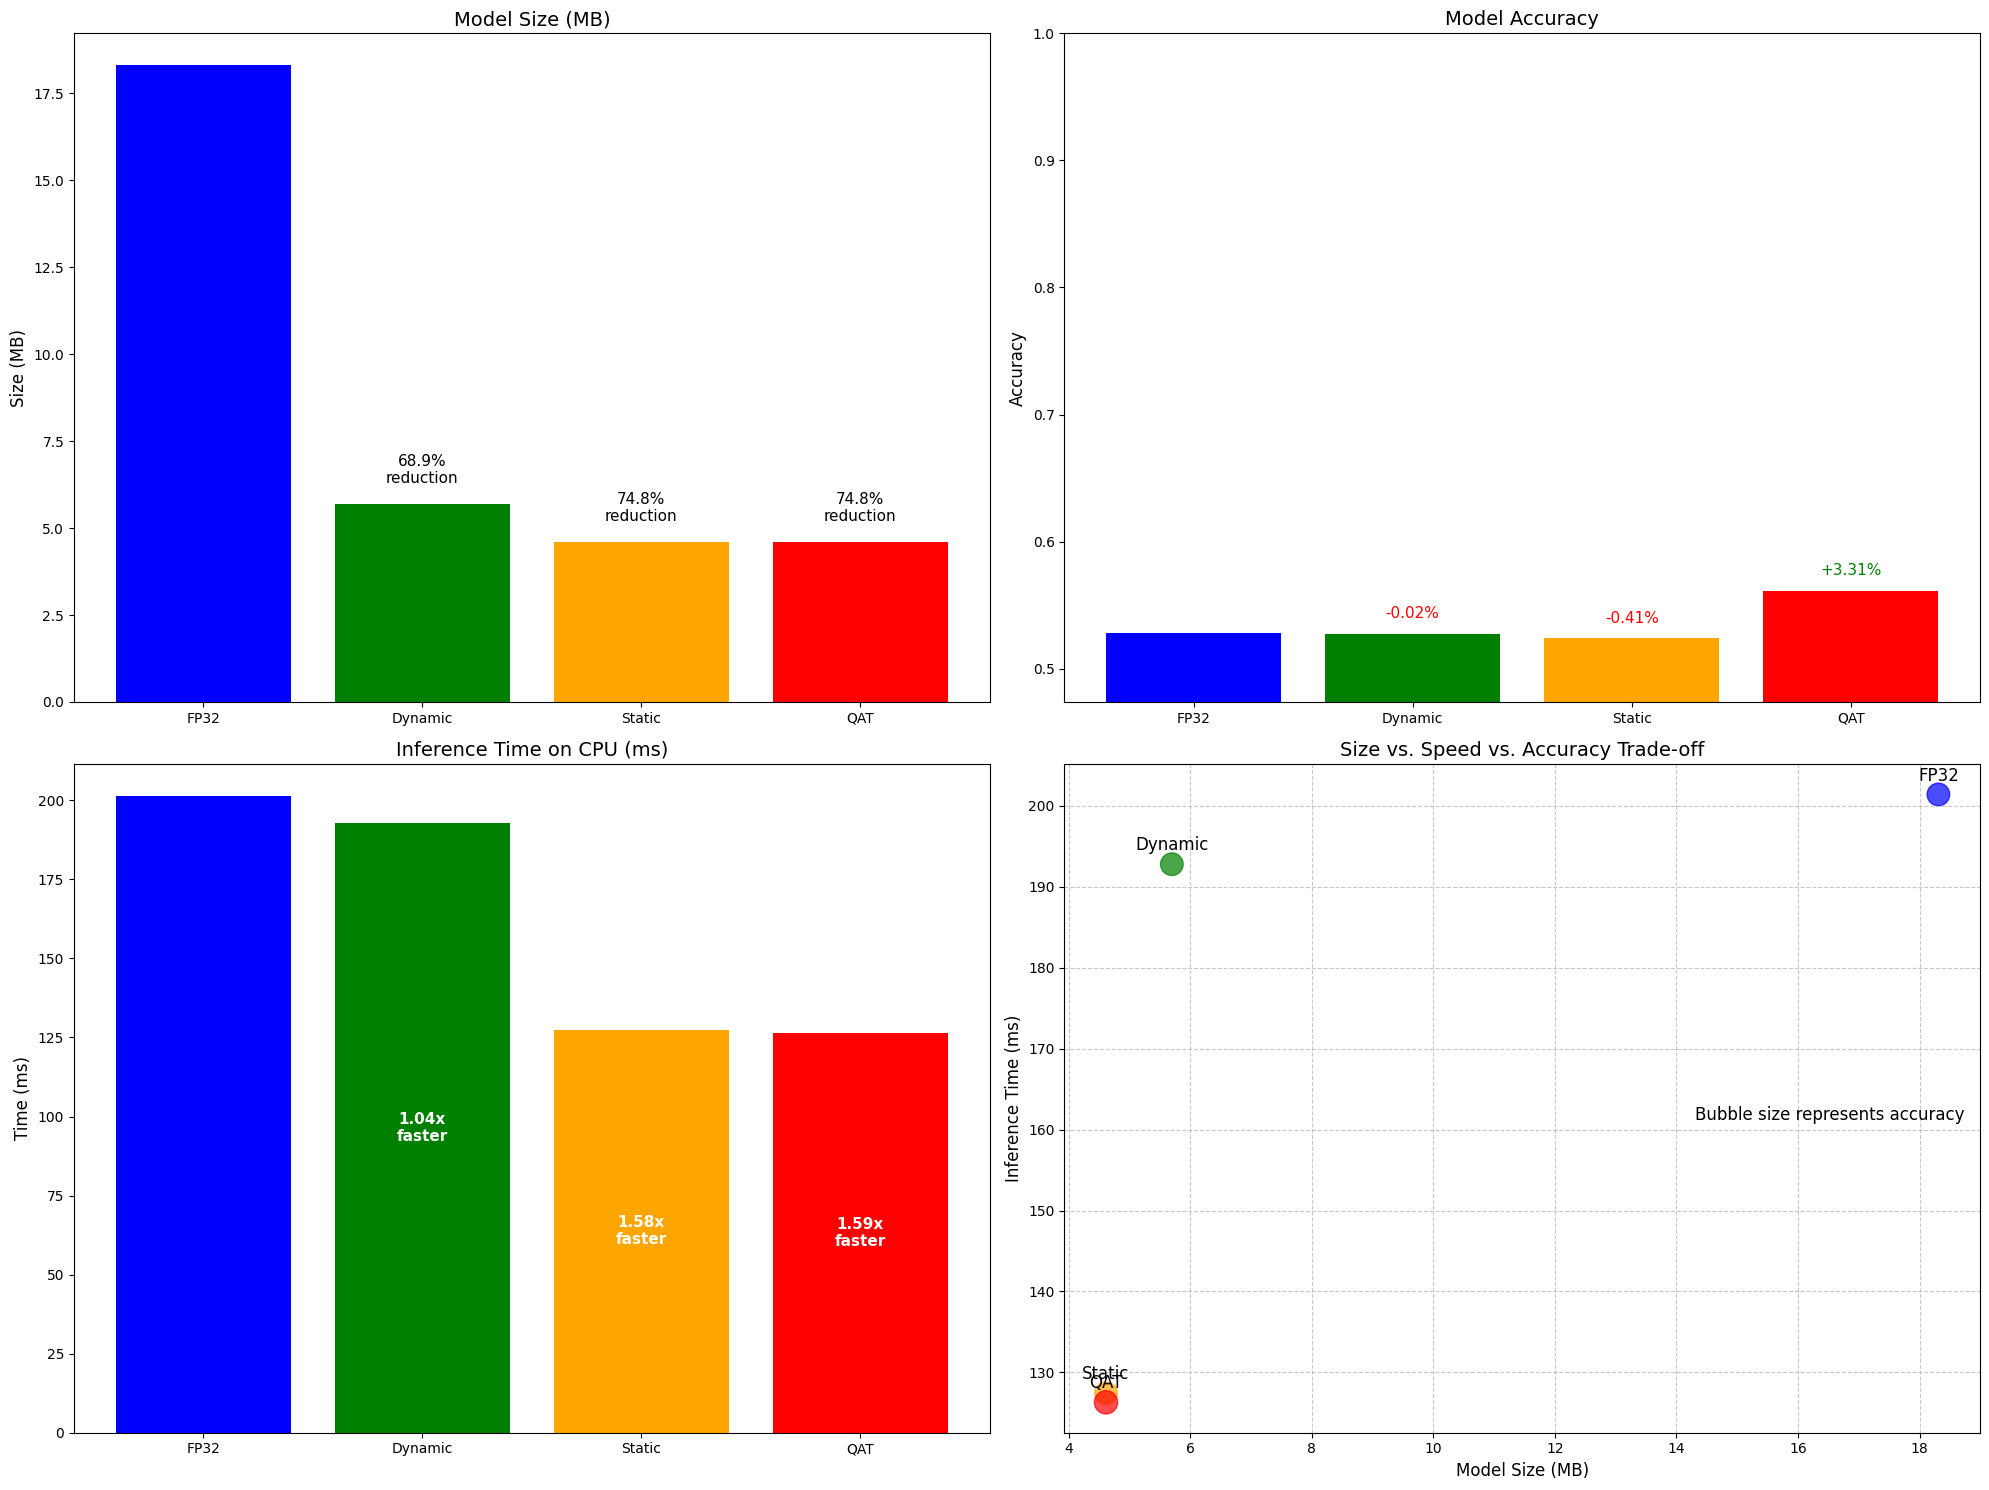

In [ ]:
# This notebook assumes you've run all previous parts and have these variables:
# - fp32_accuracy, fp32_size, fp32_cpu_inference_time (baseline)
# - dynamic_accuracy, dynamic_size, dynamic_inference_time (dynamic quantization)
# - static_accuracy, static_size, static_inference_time (static quantization)
# - qat_accuracy, qat_size, qat_inference_time (QAT)


# Results Comparison
print("\n" + "="*80)
print("QUANTIZATION COMPARISON SUMMARY")
print("="*80)
print(f"{'Model Type':<25} {'Size (MB)':<15} {'Accuracy':<15} {'Inference (ms)':<15} {'Speedup':<10}")
print(f"{'-'*80}")
# For fair comparison, use CPU times for all models
print(f"{'Original FP32 (CPU)':<25} {fp32_size:<15.2f} {fp32_accuracy:<15.4f} {fp32_cpu_inference_time*1000:<15.2f} {1.0:<10.2f}x")
print(f"{'Dynamic Quantization':<25} {dynamic_size:<15.2f} {dynamic_accuracy:<15.4f} {dynamic_inference_time*1000:<15.2f} {fp32_cpu_inference_time/dynamic_inference_time:<10.2f}x")
print(f"{'Static Quantization':<25} {static_size:<15.2f} {static_accuracy:<15.4f} {static_inference_time*1000:<15.2f} {fp32_cpu_inference_time/static_inference_time:<10.2f}x")
print(f"{'QAT':<25} {qat_size:<15.2f} {qat_accuracy:<15.4f} {qat_inference_time*1000:<15.2f} {fp32_cpu_inference_time/qat_inference_time:<10.2f}x")
print("="*80)


# Create a comprehensive visualization
plt.figure(figsize=(20, 15))


# Model Size Comparison
plt.subplot(2, 2, 1)
models = ['FP32', 'Dynamic', 'Static', 'QAT']
colors = ['blue', 'green', 'orange', 'red']
sizes = [fp32_size, dynamic_size, static_size, qat_size]
bars = plt.bar(models, sizes, color=colors)
plt.title('Model Size (MB)', fontsize=14)
plt.ylabel('Size (MB)', fontsize=12)


# Add reduction percentages
for i, bar in enumerate(bars[1:], 1):
   reduction = (1 - sizes[i]/sizes[0]) * 100
   plt.text(bar.get_x() + bar.get_width()/2, sizes[i] + 0.5,
            f"{reduction:.1f}%\nreduction",
            ha='center', va='bottom', fontsize=11)


# Accuracy Comparison
plt.subplot(2, 2, 2)
accuracies = [fp32_accuracy, dynamic_accuracy, static_accuracy, qat_accuracy]
bars = plt.bar(models, accuracies, color=colors)
plt.title('Model Accuracy', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(min(accuracies) - 0.05, 1.0)


# Add accuracy change percentages
for i, bar in enumerate(bars[1:], 1):
   change = (accuracies[i] - accuracies[0]) * 100
   color = 'green' if change >= 0 else 'red'
   prefix = '+' if change >= 0 else ''
   plt.text(bar.get_x() + bar.get_width()/2, accuracies[i] + 0.01,
            f"{prefix}{change:.2f}%",
            ha='center', va='bottom', fontsize=11, color=color)


# Inference Time Comparison
plt.subplot(2, 2, 3)
times = [fp32_cpu_inference_time*1000, dynamic_inference_time*1000,
        static_inference_time*1000, qat_inference_time*1000]
bars = plt.bar(models, times, color=colors)
plt.title('Inference Time on CPU (ms)', fontsize=14)
plt.ylabel('Time (ms)', fontsize=12)


# Add speedup labels
for i, bar in enumerate(bars[1:], 1):
   speedup = fp32_cpu_inference_time/[dynamic_inference_time, static_inference_time, qat_inference_time][i-1]
   plt.text(bar.get_x() + bar.get_width()/2, times[i]/2,
            f"{speedup:.2f}x\nfaster",
            ha='center', va='center', fontsize=11, color='white', weight='bold')


# Size-Speed-Accuracy Trade-off
plt.subplot(2, 2, 4)
plt.scatter(sizes, times, s=np.array(accuracies)*500, c=colors, alpha=0.7)


# Add labels for each point
for i, model in enumerate(models):
   plt.annotate(model,
              (sizes[i], times[i]),
              textcoords="offset points",
              xytext=(0,10),
              ha='center', fontsize=12)


plt.title('Size vs. Speed vs. Accuracy Trade-off', fontsize=14)
plt.xlabel('Model Size (MB)', fontsize=12)
plt.ylabel('Inference Time (ms)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)


# Add a legend for bubble size
plt.figtext(0.85, 0.25, "Bubble size represents accuracy", fontsize=12)


plt.tight_layout()
plt.savefig('quantization_methods_comparison.png')
plt.show()
